In [1]:
import numpy as np
import scipy as sp
from importlib import reload
import neuraltda.topology2 as tp2
import neuraltda.plotting as tpplt
import neuraltda.spikeutils as su
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

# Setup figure save path
daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)

/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/home/brad/DailyLog/20191023/


In [2]:
# Set up birds and block_paths
birds = ['B1083', 'B1083-2', 'B1056', 'B1235', 'B1075']
bps = {'B1083': '/home/brad/krista/B1083/P03S03/', 'B1075': '/home/brad/krista/B1075/P01S03/',
       'B1235': '/home/brad/krista/B1235/P02S01/', 'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
       'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
       'B1083-2': '/home/brad/krista/B1083/P03S05/'}

# Binning Parameters
windt = 10.0                      # milliseconds
dtovr = 0.5*windt                 # milliseconds
segment_info = [0, 0]             # use full Trial
cluster_group = ['Good']          # use just good clusters
comment = 'ForBettiCurvesShuffleMask'        # BootStrap Populations
bdfs = {}                         # Dictionary to store bdf

# Betti Parameters
analysis_id = 'BC'                # Generic lable
nperms = None                     # No permutation for each trial
ncellsperm = 33                   # Subsample 33 neurons from the population
dims = [0, 1, 2, 3]               # We want first four betti numbers
thresh = 4.0                     # Activation threshold
twin = np.linspace(0, 6000, 1000) # milliseconds

In [3]:
# Loop through each bird in our list and bin the data
for bird in birds:
    block_path = bps[bird]
    bfdict = tp2.dag_bin(block_path, windt, segment_info, cluster_group=cluster_group, dt_overlap=dtovr, comment=comment)
    bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
    print(bdf)
    bdfs[bird] = bdf

/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForBettiCurvesShuffleMask/20190204T172427Z-10.0-5.0.binned
/home/brad/krista/B1083/P03S05/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForBettiCurvesShuffleMask/20190408T152103Z-10.0-5.0.binned
/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForBettiCurvesShuffleMask/20190204T172437Z-10.0-5.0.binned
/home/brad/krista/B1235/P02S01/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForBettiCurvesShuffleMask/20190204T172451Z-10.0-5.0.binned
/home/brad/krista/B1075/P01S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForBettiCurvesShuffleMask/20190204T172501Z-10.0-5.0.binned


In [4]:
# Compute for all birds
betti_data = {}
for bird in birds:
    betti_data[bird] = {}
    bdf = bdfs[bird]
    block_path = bps[bird]
    
    # Compute the betti curves for the original data
    # bc
    (bc, t, t_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                             thresh, nperms, ncellsperm,
                                             dims, twin, windt, dtovr, shuffle=False)
    betti_data[bird]['bc'] = bc
    betti_data[bird]['t'] = t
    betti_data[bird]['t_ms'] = t_ms

    # Compute the betti curves for shuffled-in-time data
    # This breaks the inter-neuronal coordination
    # suffix: s
    (bcs, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                                thresh, nperms, ncellsperm,
                                                dims, twin, windt, dtovr, shuffle=True)
    betti_data[bird]['bcs'] = bcs
    betti_data[bird]['ts'] = ts
    betti_data[bird]['ts_ms'] = ts_ms

    # Compute the betti curves for shufflemask-withinstimulus data
    # suffix: st
    (bcst, tst, tst_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                                thresh, nperms, ncellsperm,
                                                dims, twin, windt, dtovr, shuffle=False, shuffle_across_stims=tp2.shuffle_mask_within_stims)
    betti_data[bird]['bcsmw'] = bcst
    betti_data[bird]['tsmw'] = tst
    betti_data[bird]['tsmw_ms'] = tst_ms

    # Compute the betti curves for shufflemask-acrossstimulus data
    # suffix: sts
    (bcsts, tsts, tsts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                                thresh, nperms, ncellsperm,
                                                dims, twin, windt, dtovr, shuffle=False, shuffle_across_stims=tp2.shuffle_mask_across_stims)
    betti_data[bird]['bcsma'] = bcsts
    betti_data[bird]['tsma'] = tsts
    betti_data[bird]['tsma_ms'] = tsts_ms



In [5]:
# All birds, All Stims, All shuffles, individually

#curve_types = {'orig': bc, 'shuff': bcs, 'shuffmask-within': bcsmw, 'shuffmask-across': bcsma}
curve_names = {'orig': 'OriginalData', 'bcs': 'OriginalShuffle', 'bcsmw': 'ShuffleMaskWithinStimulus', 'bcsma': 'ShuffleMaskAcrossStimulus'}
shuffle_types = ['bcs', 'bcsmw', 'bcsma']

Bird B1056 Shuffle type bcs
Bird B1056 Shuffle type bcsmw
Bird B1056 Shuffle type bcsma


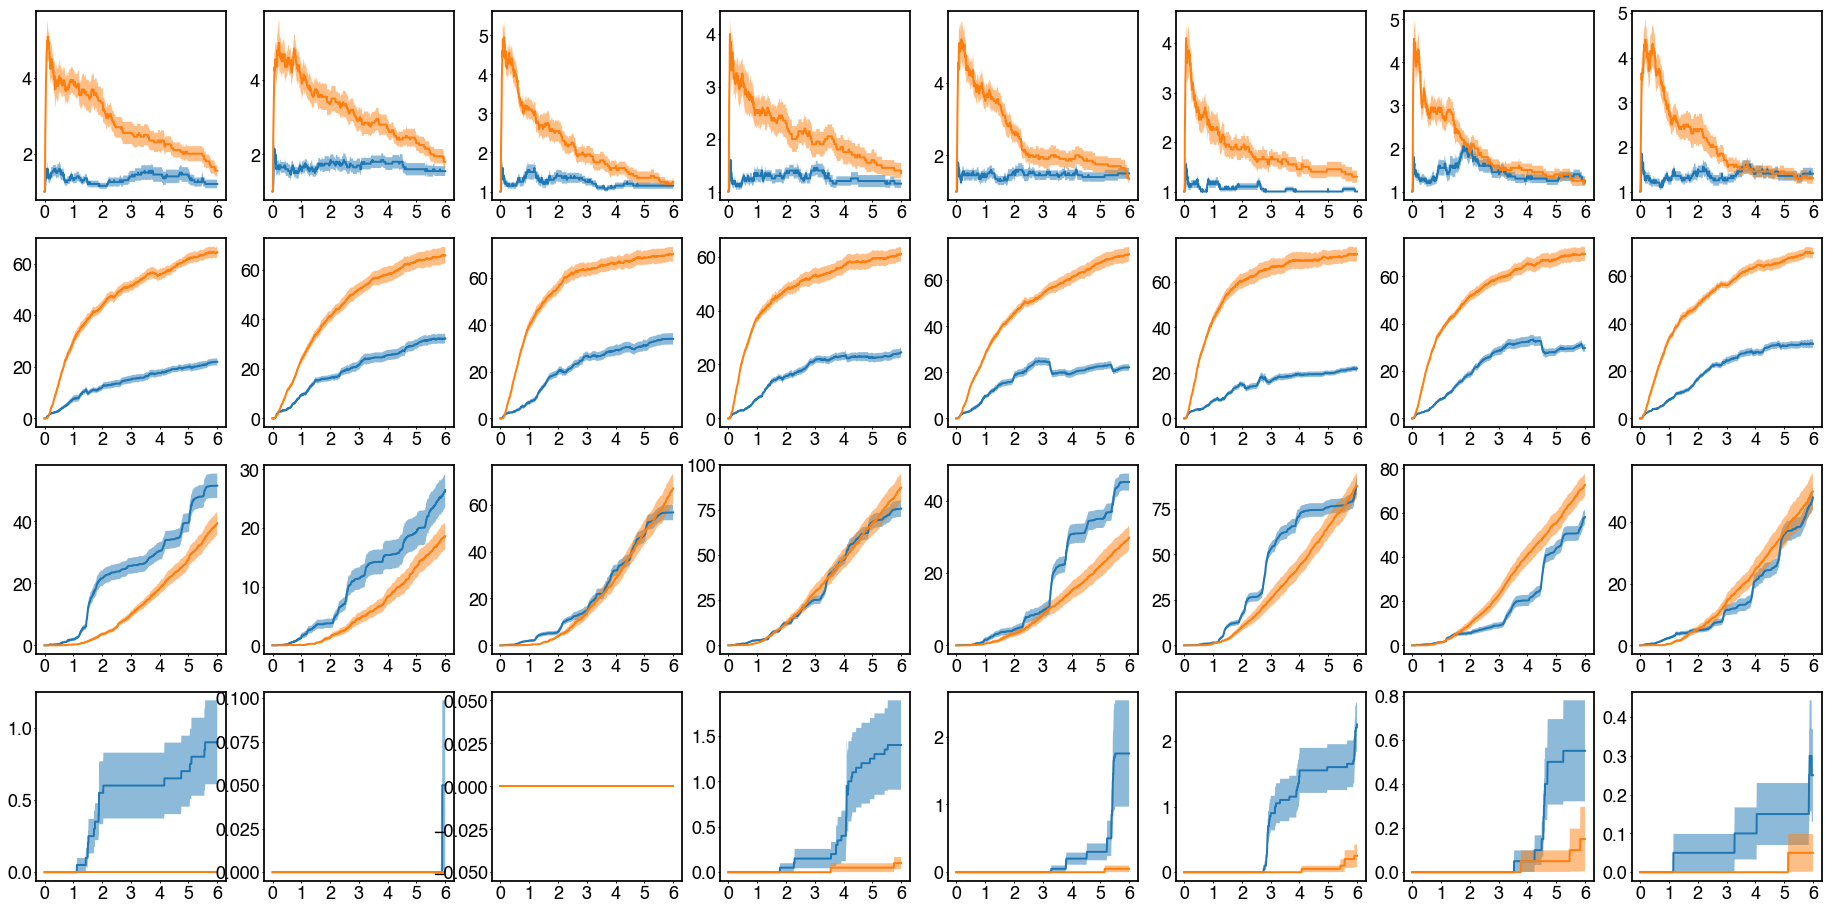

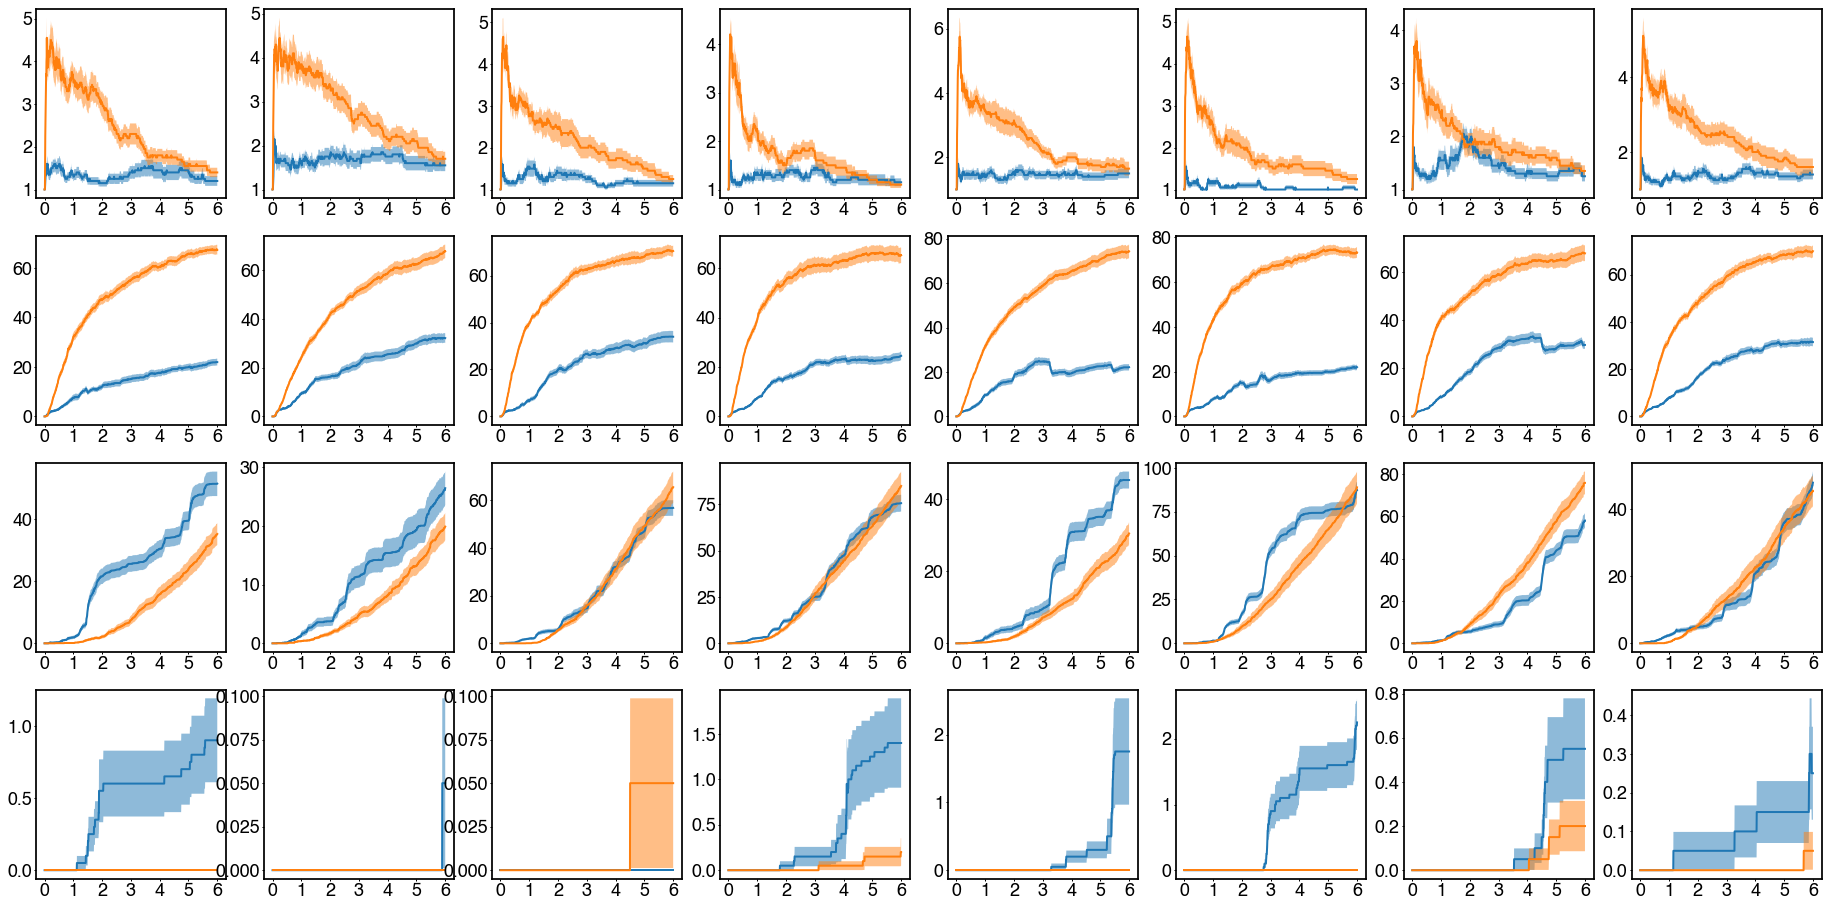

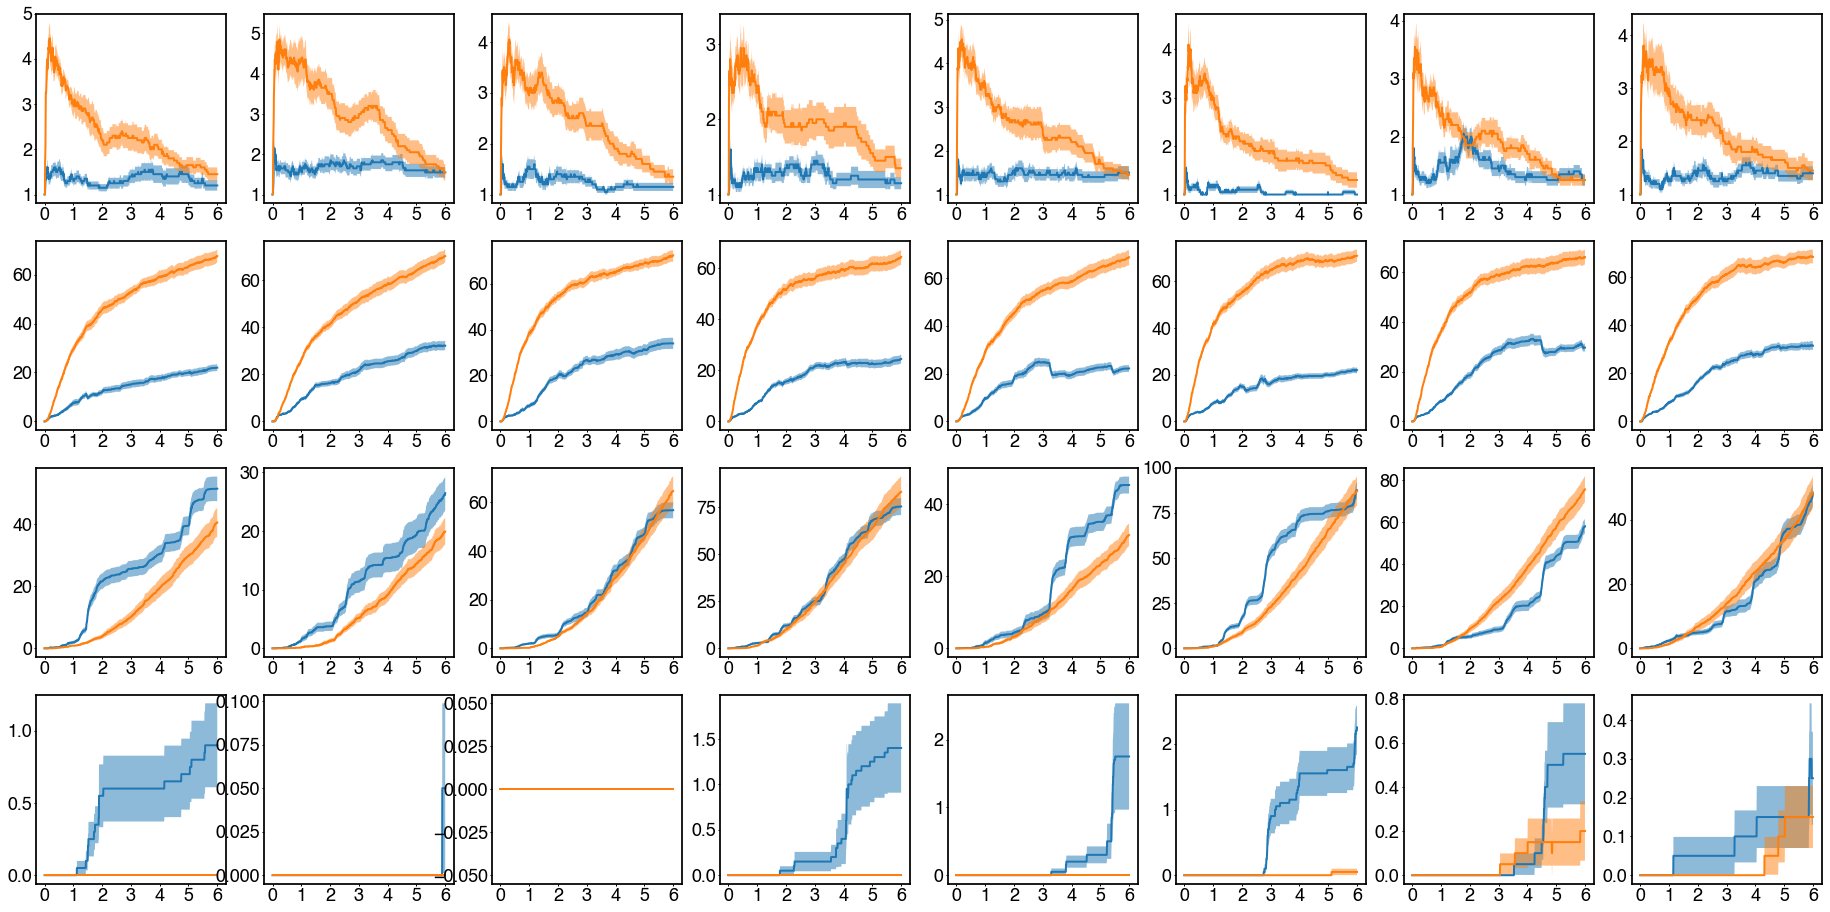

In [9]:
for bird in birds:
    bird_betti_data = betti_data[bird]
    for shuffle_suffix in shuffle_types:

        # generate figure and axes
        plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
        figname=curve_names[shuffle_suffix]
        fig, axs = plt.subplots(4, 8, figsize=(32, 16), sharey=False)
        axs = axs.flatten()
        
        # Compute the mean and stderr
        bc = bird_betti_data['bc']
        bcs = bird_betti_data[shuffle_suffix]
        bc_plot_dict = tp2.compute_mean_stderr_betti_curves(bc)     # Real curves 
        bcs_plot_dict = tp2.compute_mean_stderr_betti_curves(bcs)   # Shuffled curves 

        bettis = [0, 1, 2, 3]              # Betti number to plot
        stims = np.array(list(bc.keys()))  # Stimuli names
        stimIDs = range(8)                 # ID numbers of stimuli to plot
        stims_to_plot = stims[stimIDs]     # names of stimuli to plot
#         print('Bird stims: {}'.format(stims))
#         print('Plotting stims: {}'.format(stims_to_plot))

        t_ms = bird_betti_data['t_ms']
        print("Bird {} Shuffle type {}".format(bird, shuffle_suffix))
        for betti in bettis:
            for ind, stim in enumerate(stims_to_plot):
                ax = axs[len(stimIDs)*betti + ind]
                tpplt.plot_betti_curve(bc_plot_dict, t_ms, stim, betti, ax)
                tpplt.plot_betti_curve(bcs_plot_dict, t_ms, stim, betti, ax)
        plt.savefig(os.path.join(figsavepth, '{}_{}_{}_allstim.pdf'.format(bird,figname, thresh)))

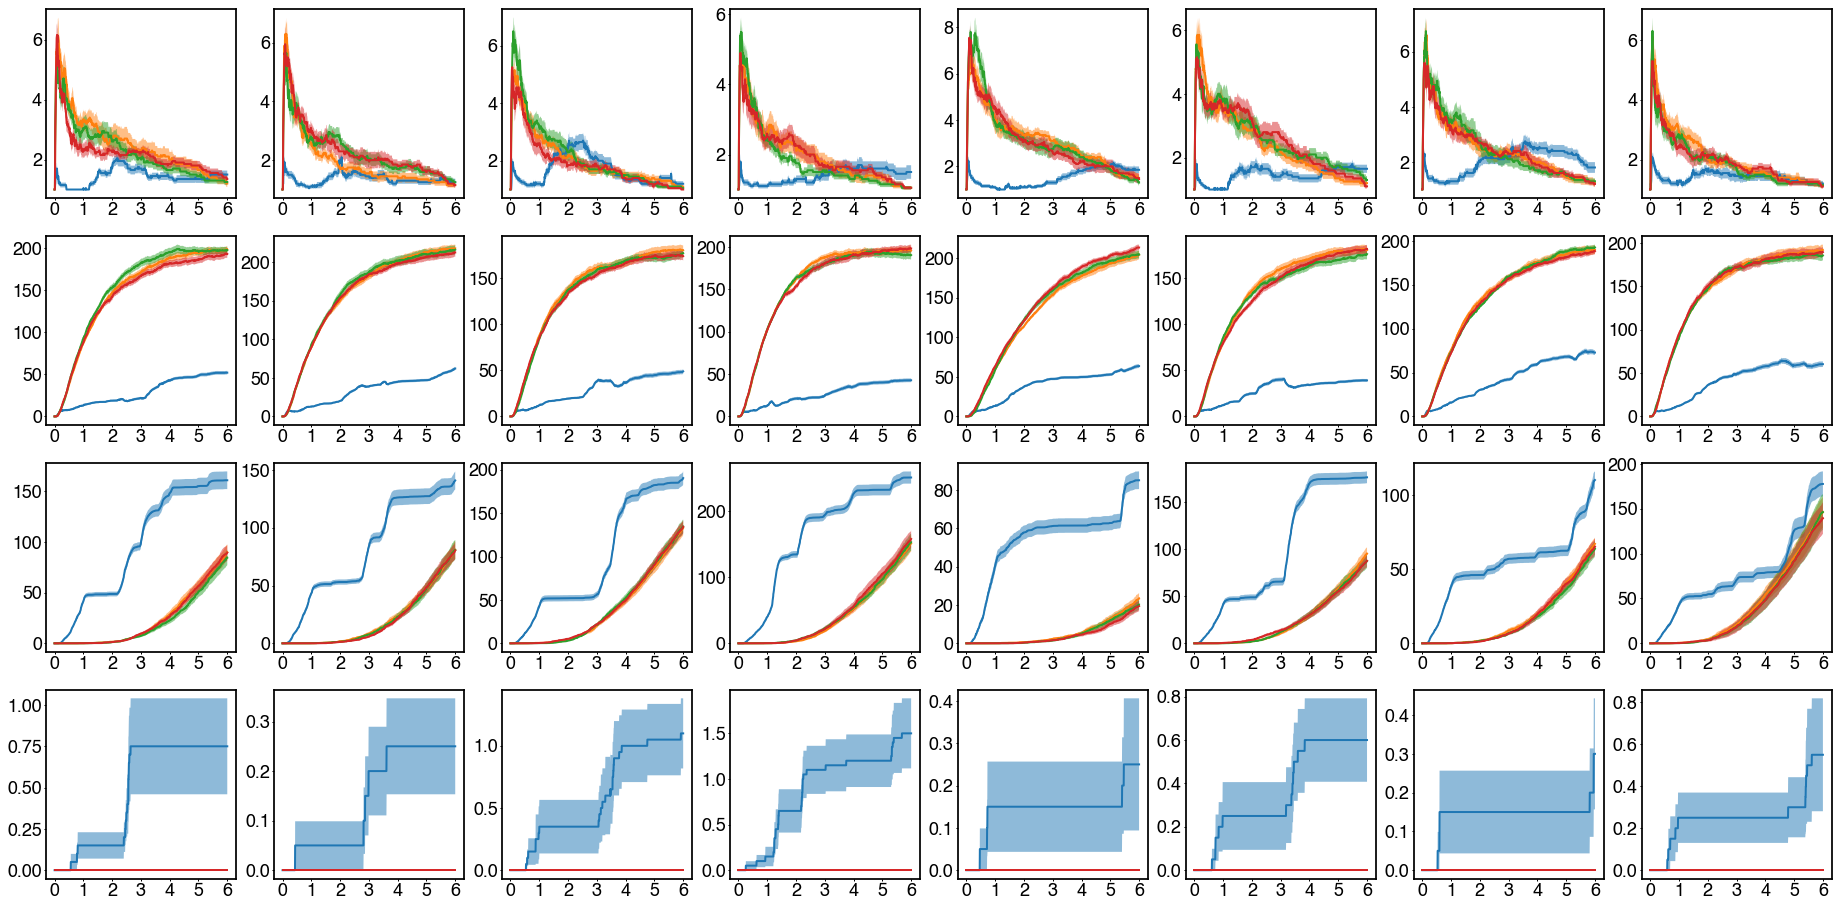

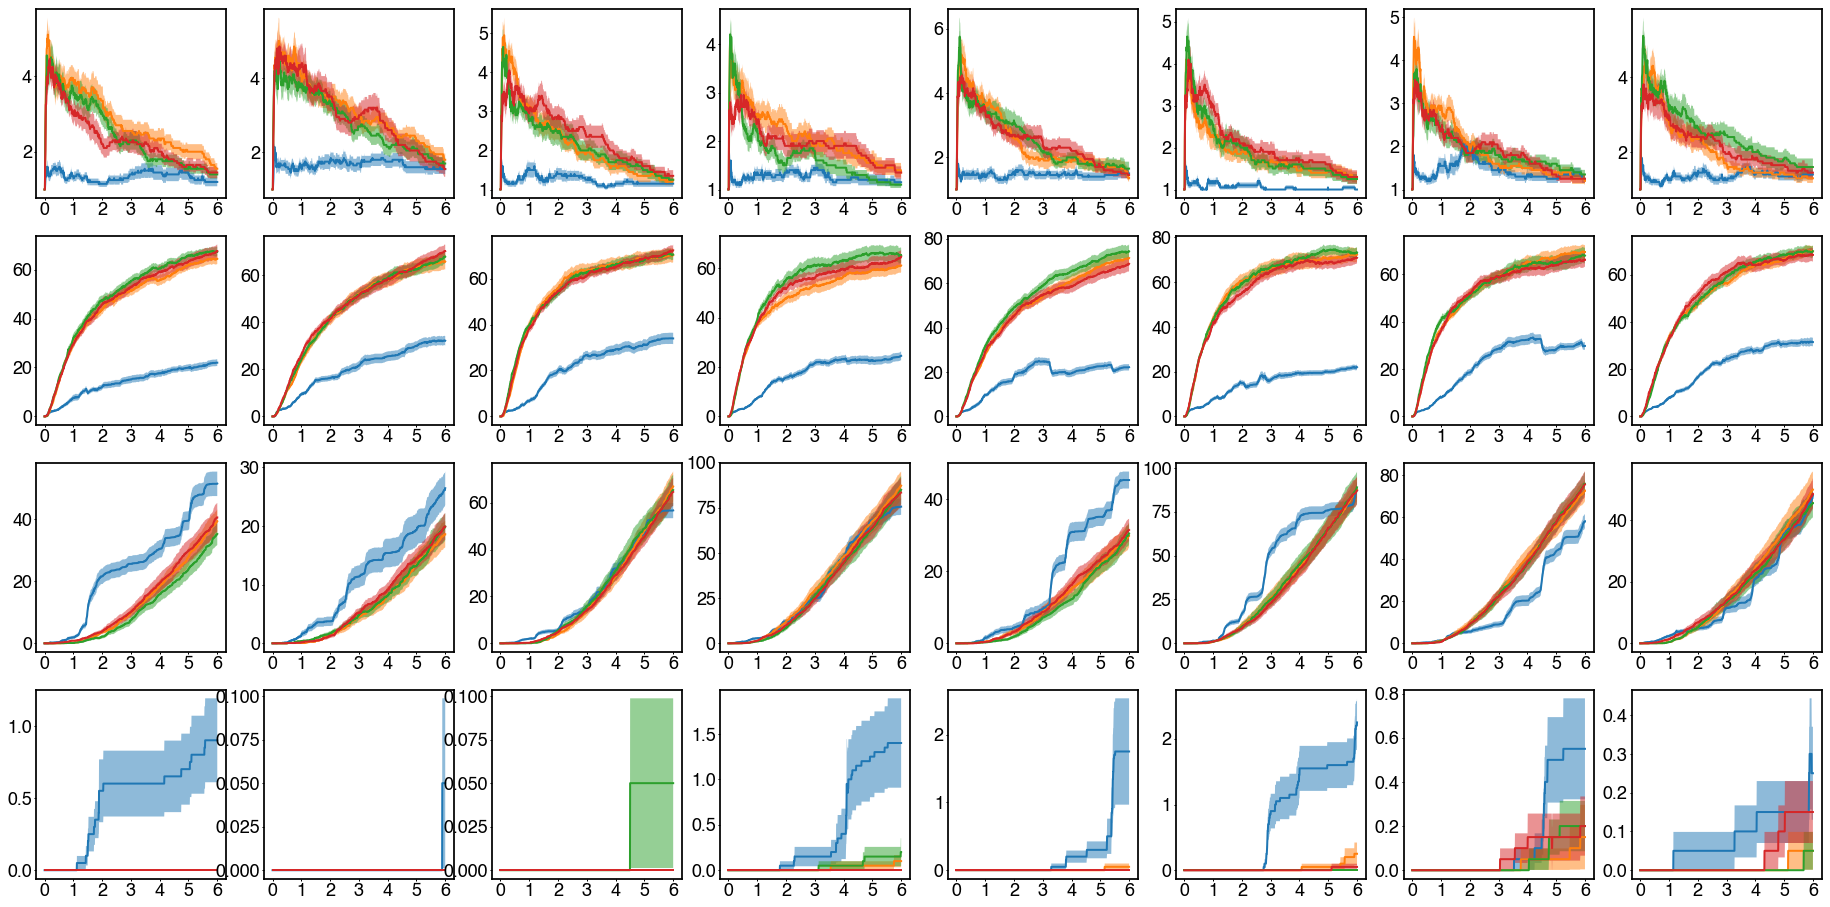

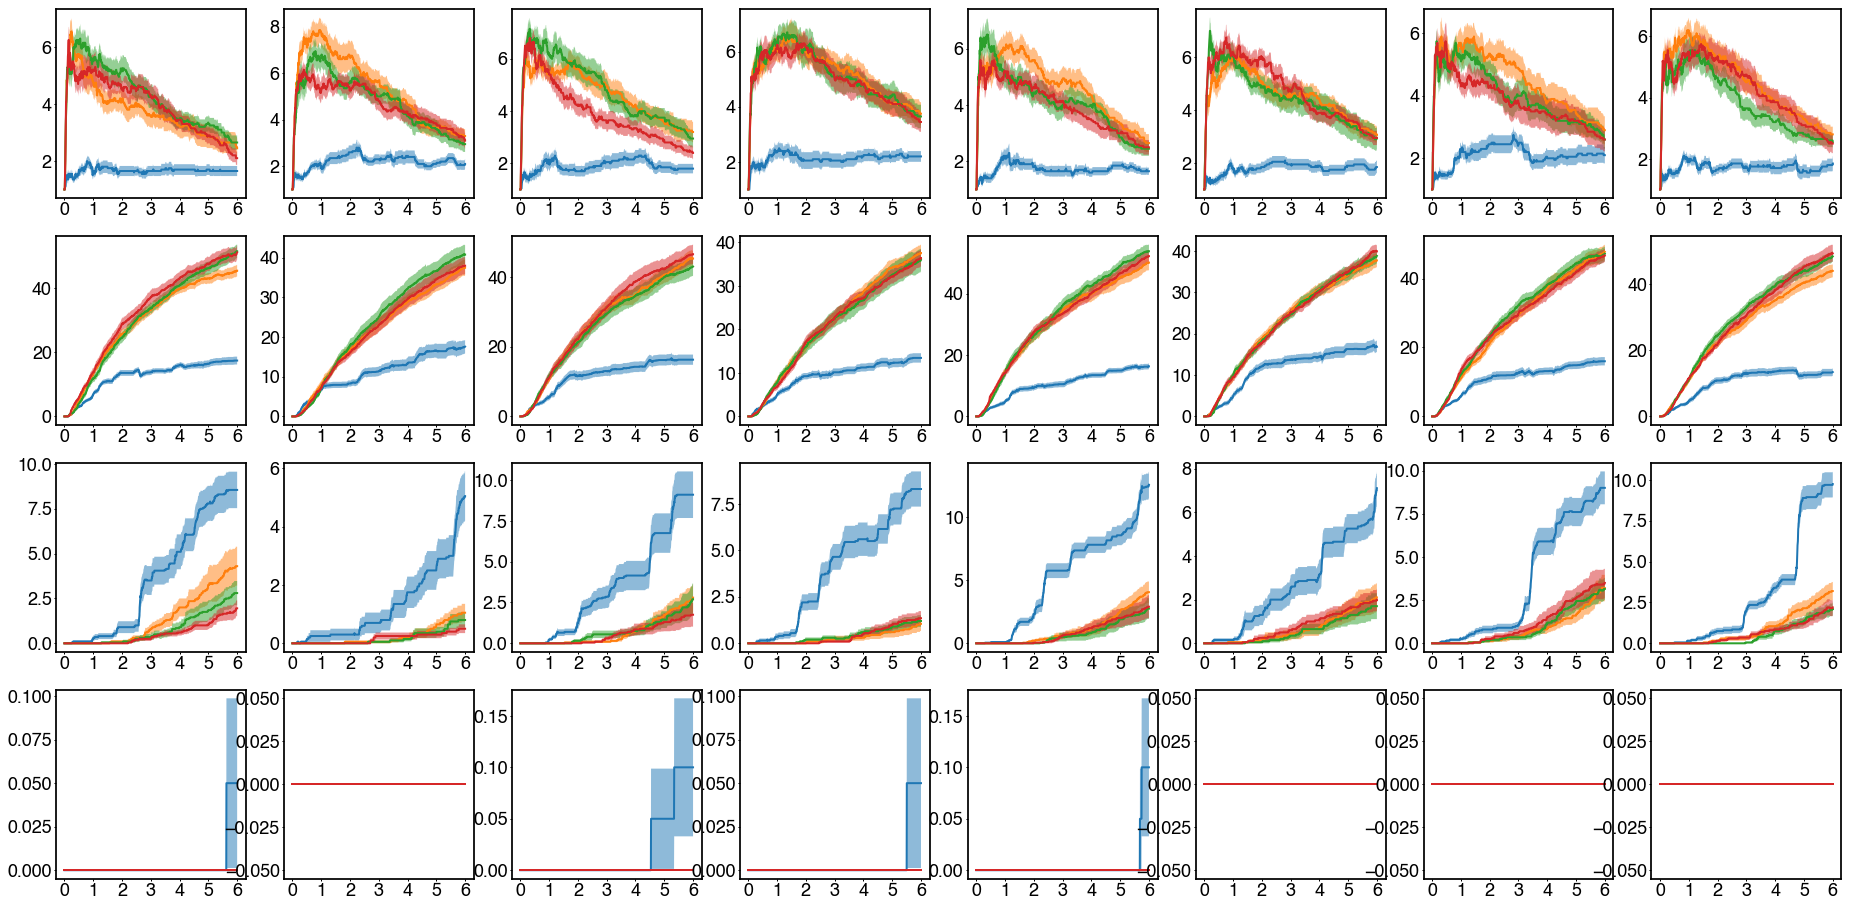

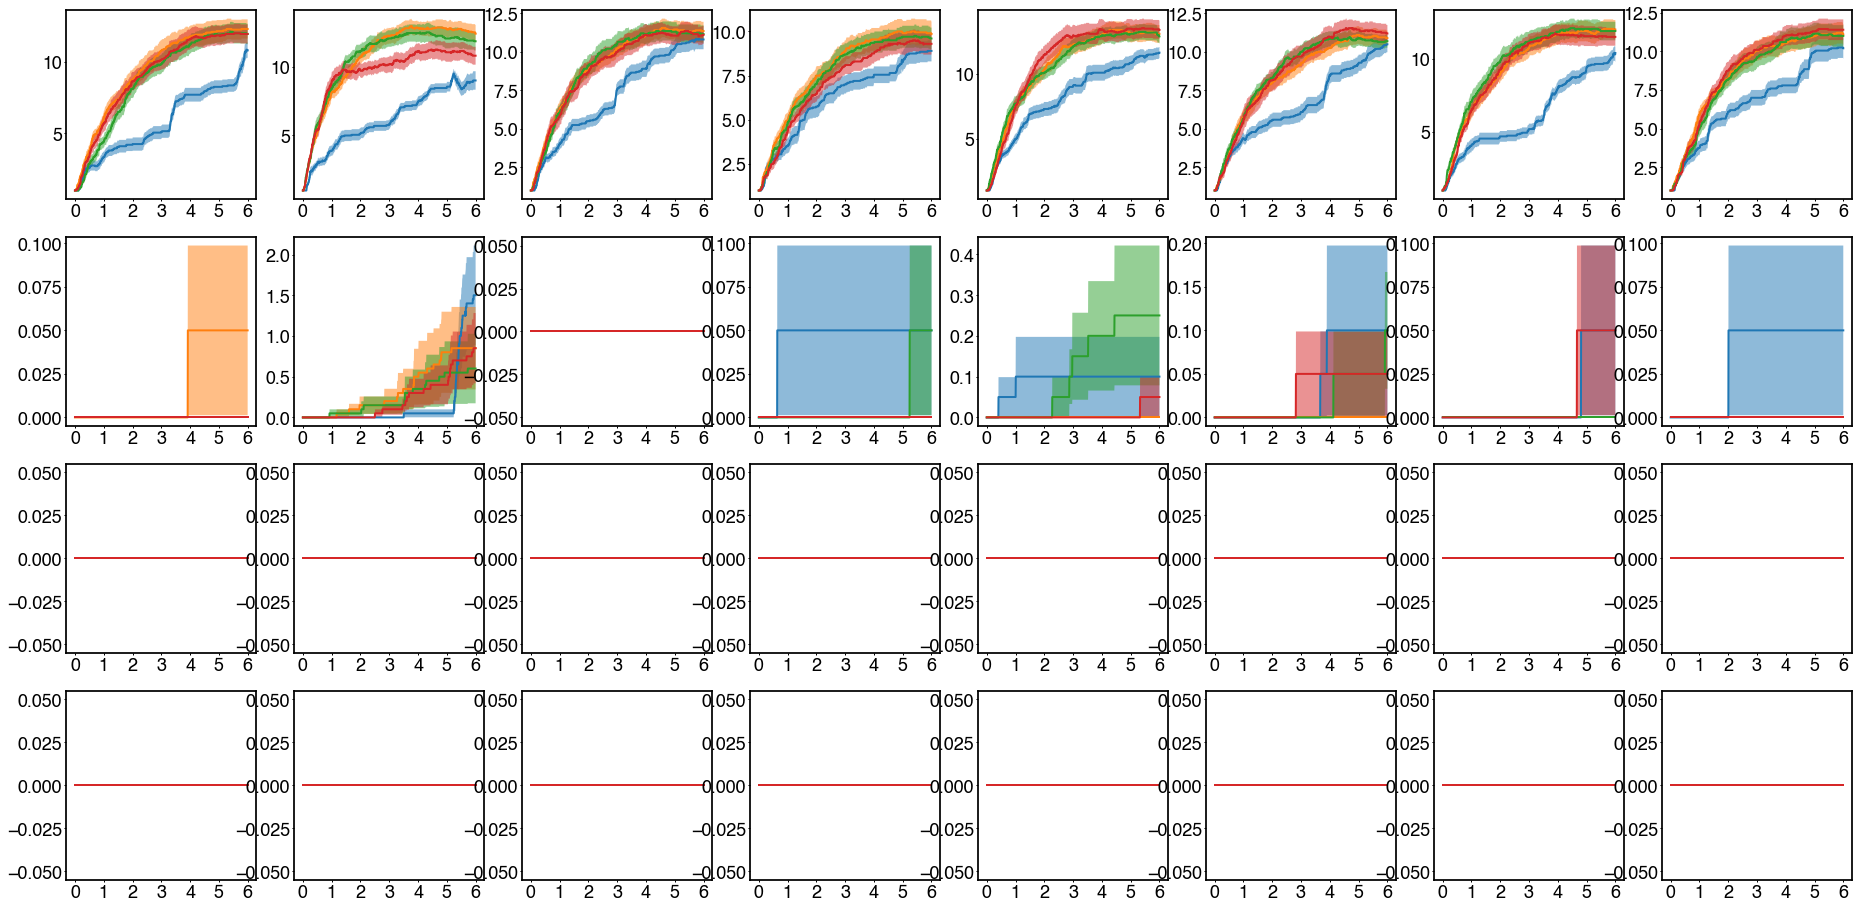

In [10]:
for bird in birds:
    bird_betti_data = betti_data[bird]
        # generate figure and axes
    plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
    fig, axs = plt.subplots(4, 8, figsize=(32, 16), sharey=False)
    axs = axs.flatten()
    bc = bird_betti_data['bc']
    bettis = [0, 1, 2, 3]              # Betti number to plot
    stims = np.array(list(bc.keys()))  # Stimuli names
    stimIDs = range(8)                 # ID numbers of stimuli to plot
    stims_to_plot = stims[stimIDs]     # names of stimuli to plot
    bc_plot_dict = tp2.compute_mean_stderr_betti_curves(bc) 
    t_ms = bird_betti_data['t_ms']
    for betti in bettis:
        for ind, stim in enumerate(stims_to_plot):
            ax = axs[len(stimIDs)*betti + ind]
            tpplt.plot_betti_curve(bc_plot_dict, t_ms, stim, betti, ax)
    for shuffle_suffix in shuffle_types:  
        bcs = bird_betti_data[shuffle_suffix]
        bcs_plot_dict = tp2.compute_mean_stderr_betti_curves(bcs)   # Shuffled curves 
        for betti in bettis:
            for ind, stim in enumerate(stims_to_plot):
                ax = axs[len(stimIDs)*betti + ind]

                tpplt.plot_betti_curve(bcs_plot_dict, t_ms, stim, betti, ax)
        plt.savefig(os.path.join(figsavepth, '{}_{}_allstim_allshuff.pdf'.format(bird, thresh)))

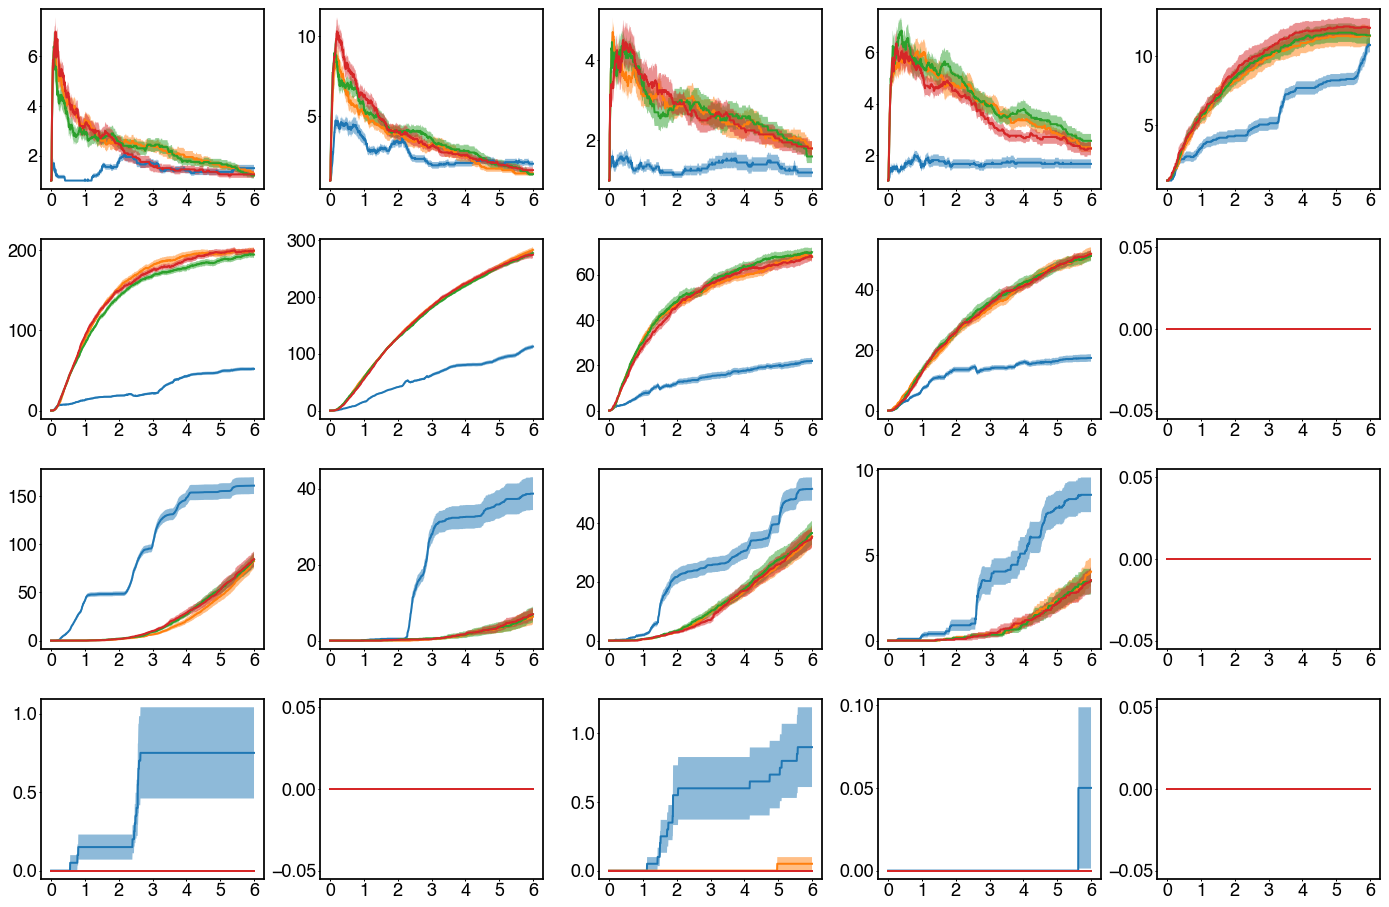

In [13]:

fig, axs = plt.subplots(4, 5, figsize=(24, 16), sharey=False)
axs = axs.flatten()
for ind, bird in enumerate(birds):
    bird_betti_data = betti_data[bird]
        # generate figure and axes
    plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
    
    
    bc = bird_betti_data['bc']
    bettis = [0, 1, 2, 3]              # Betti number to plot
    stims = np.array(list(bc.keys()))  # Stimuli names
    stimIDs = [0]                 # ID numbers of stimuli to plot
    stims_to_plot = stims[stimIDs]     # names of stimuli to plot
    stim = stims[0]
    bc_plot_dict = tp2.compute_mean_stderr_betti_curves(bc) 
    t_ms = bird_betti_data['t_ms']
    for betti in bettis:
        ax = axs[len(birds)*betti + ind]
        tpplt.plot_betti_curve(bc_plot_dict, t_ms, stim, betti, ax)
        for shuffle_suffix in shuffle_types:  
            bcs = bird_betti_data[shuffle_suffix]
            bcs_plot_dict = tp2.compute_mean_stderr_betti_curves(bcs)   # Shuffled curves 
            tpplt.plot_betti_curve(bcs_plot_dict, t_ms, stim, betti, ax)
plt.subplots_adjust(wspace=0.25, hspace=0.28)   
plt.savefig(os.path.join(figsavepth, 'AllBirds_1stim_allshuff.pdf'.format(bird, thresh)))

Bird B1083 Shuffle type bcs


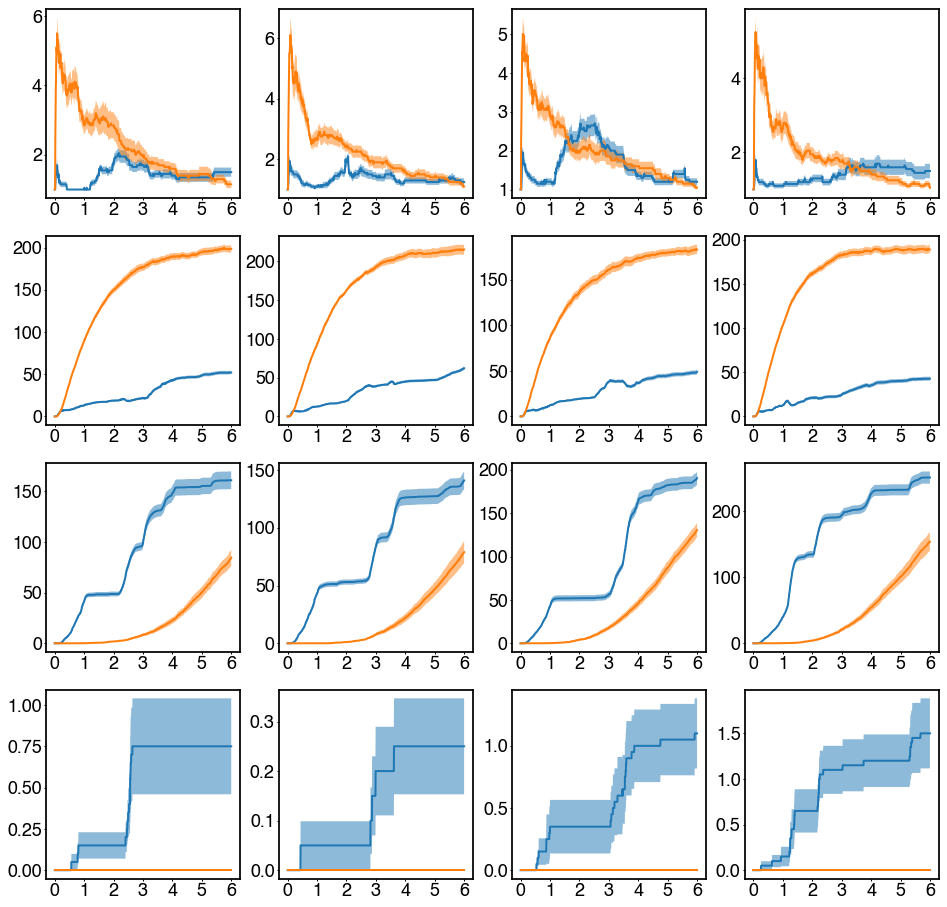

In [12]:


bird = 'B1083'
shuffle_suffix = 'bcs'
bird_betti_data = betti_data[bird]
# generate figure and axes
plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
figname=curve_names[shuffle_suffix]
fig, axs = plt.subplots(4, 4, figsize=(16, 16), sharey=False)
axs = axs.flatten()

# Compute the mean and stderr
bc = bird_betti_data['bc']
bcs = bird_betti_data[shuffle_suffix]
bc_plot_dict = tp2.compute_mean_stderr_betti_curves(bc)     # Real curves 
bcs_plot_dict = tp2.compute_mean_stderr_betti_curves(bcs)   # Shuffled curves 

bettis = [0, 1, 2, 3]              # Betti number to plot
stims = np.array(list(bc.keys()))  # Stimuli names
stimIDs = range(4)                 # ID numbers of stimuli to plot
stims_to_plot = stims[stimIDs]     # names of stimuli to plot
#         print('Bird stims: {}'.format(stims))
#         print('Plotting stims: {}'.format(stims_to_plot))

t_ms = bird_betti_data['t_ms']
print("Bird {} Shuffle type {}".format(bird, shuffle_suffix))
for betti in bettis:
    for ind, stim in enumerate(stims_to_plot):
        ax = axs[len(stimIDs)*betti + ind]
        tpplt.plot_betti_curve(bc_plot_dict, t_ms, stim, betti, ax)
        tpplt.plot_betti_curve(bcs_plot_dict, t_ms, stim, betti, ax)
plt.savefig(os.path.join(figsavepth, '{}_{}_{}_allstim.pdf'.format(bird,figname, thresh)))